
## Random Forest regressor for porosity predictions from well and 3D seismic data

#### John Franey
#### Department of Geological Sciences, The University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)

### Executive Summary

This dataset contains 209 wells with seismic data coverage; 31 of these wells contain spontaneous potential (SP) and porosity logs. The remaining 178 wells contain only the SP log. The goal of this project is to predict a porosity log for these 178 wells from the SP logs and seismic attributes. Recursive feature elimiation was used to select for predictor features as well as to reduce computational cost. A Random Forest Regressor was trained and tested on the data and the error in the predicted porosity was found to have an mean error of 0.034% and a standard deviation of 4.97%. This method is recommended for use of generating porosity values at the field scale.

### Data Background

The data comes from two sources, **well logs** and a **3D seismic survey**. Data has been scrubbed of UWI and spatial location; data can be found [here](https://github.com/franathan/SSML_final_project).

The wells contain three logs:
- Depth (ft)
- Spontaneous Potential (mV)
- Porosity (%)

The seismic data contains four attributes:
- Amplitude
- Phase (degrees)
- Instantaneous frequency (Hz)
- Relative acoustic Impedence (kg/m^2 * m/s^2)


 There are 8947 records in the data.

In [1]:
# Imports used for project

import pandas as pd    # Data Management 
import os    # Set working directory
import numpy as np    # Basic mathematical operations
import seaborn as sns    # Plotting
import matplotlib.pyplot as plt    # Plotting
from sklearn.feature_selection import RFE    # Recursive Feature Elmination
from sklearn.ensemble import RandomForestRegressor    # Model used in project
from sklearn.model_selection import train_test_split    # Split Data into train and test
from sklearn.model_selection import RandomizedSearchCV    # For hyperparameter tuning
import sklearn.metrics as metrics    # Metrics for random forest regressor
from scipy import stats    # Used to compute histogram metrics

### Data Preparation 

Data is read in as a dataframe, This data has been scrubbed of well UWI numbers and spatial locations. Each measurment along the well borehole is spaced between ~25–45 ft. This depends on the vertical resloution of the seismic survey.

In [2]:
# Set working directory and read in data
# This dataframe contains all wells that have a Porosity log
os.chdir('/Users/johnfraney/PycharmProjects/Geostats/ssml_data')
data = pd.read_csv('final_project_data.csv')
data.head()

,Depth,PHIS_SS,SP_NRM,AI,Freq,Amp,Phase
0,4893.0,0.374,-9.166,682.68,6.88,1787.14,23.52
1,4936.0,0.387,-15.263,4146.97,11.15,1722.02,162.62
2,4979.0,0.330,-8.102,4163.79,8.03,2121.89,-35.02
3,5001.0,0.341,-28.829,-2102.03,6.77,2239.95,20.50
4,5044.0,0.343,-3.422,-6826.19,4.96,2312.88,113.53


Let's look at an initial pairplot of the entire data. The histograms going across the diagonal of the plot can be used to quicly check for outliers. Ocular inspection shows that there are no outliers or odd distributions that need to be corrected. (Data cleaning occured on this data prior to the project).

Porosity shows no obvious relationship with any of the features. This motivates us to use a more complex model, such as a Random Forest Regressor. Prior geologic knowledge is also used to make this decision. Porosity is related to depth from compaction and lithology—which SP and seismic data can help inform.

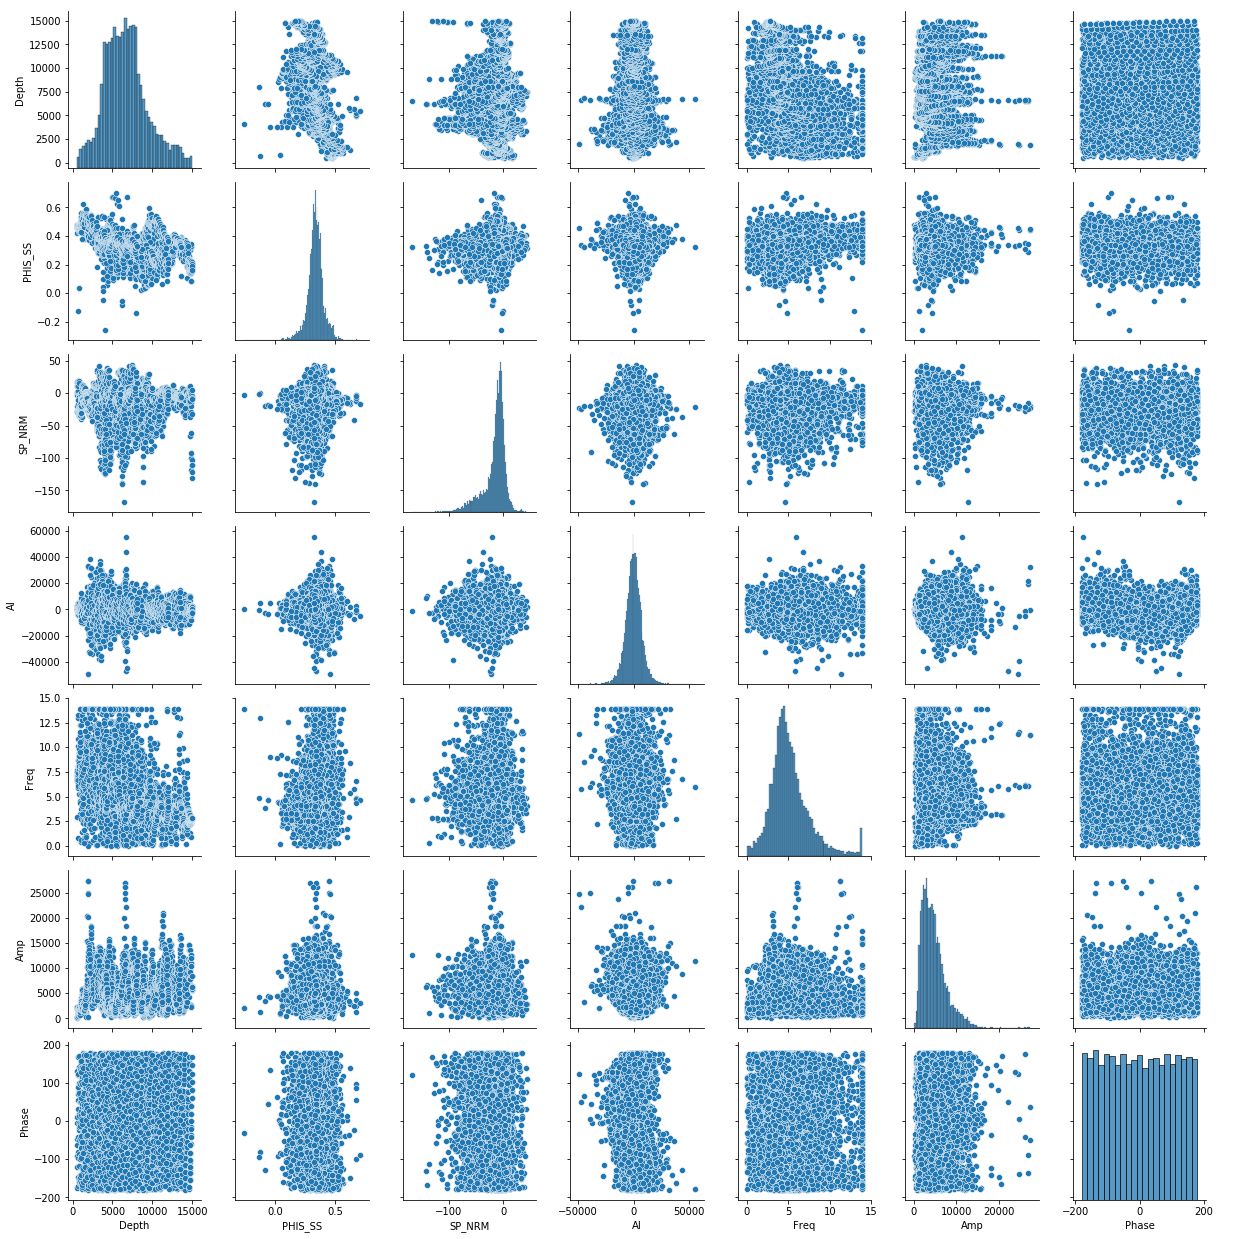

In [3]:
sns.pairplot(data)
plt.show()

### Feature Selection
First, the number of features used in the model will be reduced to improve computation time. This is done with the recursive feature elemination from Sklearn. Reducing the number of features will also help deal with the curse of dimensionality. As the number of features increase, our overall coverage decreases. 

Recursive feature elimination works by iteratively eliminating features until a given number of features remain. By defeault the Sklearn RFE keeps half of the features, meaning that for this data we will keep 3 out of the orginal 6 features.

In [4]:
# Data is split into training and testing data
predictors = ['Depth', 'SP_NRM', 'AI', 'Freq', 'Amp', 'Phase'] # features
response = 'PHIS_SS' # response variable

train_x, test_x, train_y, test_y = train_test_split(data.loc[:, predictors],
                                                    data.loc[:, response],
                                                    test_size=.2)
# Feature Selection
# code modified from Will Koehrsen
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# The same model that will be used to model porosity is used for the feature elmination (Random Forest)

rf = RandomForestRegressor()
rfe = RFE(estimator=rf, step=1) 
rfe.fit(train_x, train_y)

# A dataframe is created with the feature and its assocaited rank from the recursive Feature Elimination
# rank of 1 is best
vardf = pd.DataFrame(zip(train_x.columns, rfe.ranking_), columns=['Variable', 'Ranking'])
vardf_selected = vardf[vardf['Ranking'] == 1]
good_features = list(vardf_selected.Variable.values)
print('The selected features are: {}'.format(good_features))
vardf.head(6)

The selected features are: ['Depth', 'SP_NRM', 'Amp']


,Variable,Ranking
0,Depth,1
1,SP_NRM,1
2,AI,3
3,Freq,2
4,Amp,1
5,Phase,4


### Hyperparamter Tuning
The model will only use **Depth**, **SP**, and **Amplitude** to predict **Porosity**.
The other features will be filtered out, and a new train test split is computed.

A random search will be performed on a range of possible hyperparameters using the RandomSearchCV from Sklearn. This will iterate 100 times over a random selection of hyperparameters and keep the best estimator. Additionally, in each iteration the training data is split into a subset of 3 groups for cross-validation. Using 3 subsets is an abritrary selection, however a higher number of subsets increase computational costs.

The random search will arrive at a less optimal solution compared to grid search, but is much faster.

In [5]:
# New train test split, using only the remaining features of the recurssive feature elmination
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, good_features],
                                                    data.loc[:, 'PHIS_SS'],
                                                    test_size=.2)

# Hyperparamter tuning

# Create a dictionary of the range of the hyperparameters
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False] # Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print('Range of Hyperparamters')
for key, value in random_grid.items():
    print('{}: {}'.format(key, value))
print('----------------------------------')
# Random Search
rf = RandomForestRegressor() #initate model

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, n_jobs=-1)
rf_random.fit(train_x, train_y)
print('Tuned Hyperparamters from the random search')
print(rf_random.best_params_)

Range of Hyperparamters
n_estimators: [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
max_features: ['auto', 'sqrt']
max_depth: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]
min_samples_split: [2, 5, 10]
min_samples_leaf: [1, 2, 4]
bootstrap: [True, False]
----------------------------------
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 38.0min finished


Tuned Hyperparamters from the random search
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}


The best combination of hyperparameters from the random search are stored. These hyperparameters will be used to train another random forest regressor. This model will be tested against the testing data to determine the summary statistics. 

In [6]:
# Tuned Hyperparameters
#{'n_estimators': 1600,
# 'min_samples_split': 2,
# 'min_samples_leaf': 1,
# 'max_features': 'auto',
# 'max_depth': 100,
# 'bootstrap': True}


# Create predictions from the testing data and compute error
rf_tuned = rf_random.best_estimator_
predictions = rf_tuned.predict(test_x)
errors = predictions - test_y

### Model Statisitcs 

Since this model has three predictor features, simlpe visualizations of the model are not possible. We must rely on summary statistics and error plots for visuals.

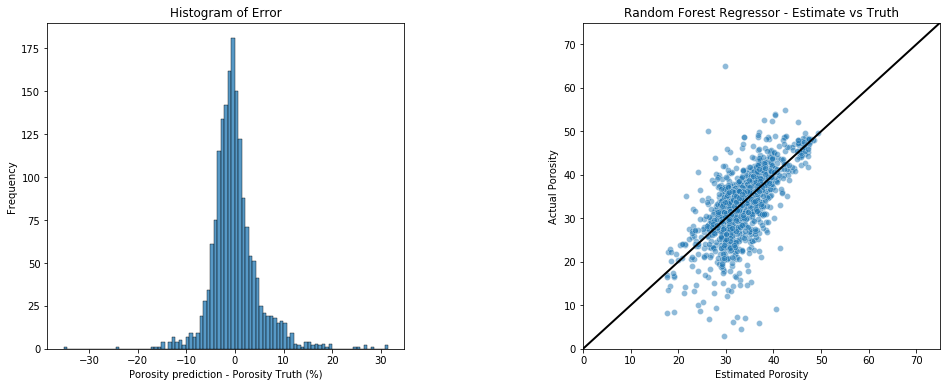

---------Random Forest Regressor Summary Statistics---------
Mean of Error: -0.034%
Standard Deviation of Error: 4.97%
Explained Variance: 0.444
Mean Absolute Error: 0.034
Mean Squared Error: 0.002


In [7]:
# Summary Statistics and Error plots

# Since the prediction is porosity, we will change the value to percent
errors_p = errors * 100
predictions_p = predictions * 100
test_y_p = test_y * 100

# Histogram of error & Truth Plot
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.histplot(errors_p)
plt.title('Histogram of Error')
plt.ylabel('Frequency')
plt.xlabel('Porosity prediction - Porosity Truth (%)')

plt.subplot(122)
sns.scatterplot(x=predictions_p, y=test_y_p, palette='tomato', alpha=.5)
plt.plot([0, 75], [0, 75], linewidth=2, color='k')
plt.title('Random Forest Regressor - Estimate vs Truth')
plt.xlabel('Estimated Porosity')
plt.ylabel('Actual Porosity')
plt.xlim([0, 75])
plt.ylim([0, 75])
plt.subplots_adjust(wspace=.5)
plt.show()

# Calculate Summary statistics
# These metrics come from Dr. Pyrcz's Subsurface Machine Learning Course
# https://github.com/GeostatsGuy/PythonNumericalDemos
mean_err = round(np.mean(errors_p), 3)
std_err = round(np.std(errors_p), 3)

# A suite of metrics can be calculated from the metrics module of sklearn
# Descriptions are paraphrases of functions from sklearn documentation
# https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

# How much of the variance in the data is explained by the model (1 is best score; lower values are worse)
explained_variance = round(metrics.explained_variance_score(test_y, predictions), 3)
# Risk metric corresponding to absolute value of the L1 norm
mean_abs_error = round(metrics.mean_absolute_error(test_y, predictions), 3)
# Risk metric of the L2 norm
mse = round(metrics.mean_squared_error(test_y, predictions), 3)



print('---------Random Forest Regressor Summary Statistics---------')
print('Mean of Error: {}%'.format(mean_err))
print('Standard Deviation of Error: {}%'.format(std_err))
print('Explained Variance: {}'.format(explained_variance))
print('Mean Absolute Error: {}'.format(mean_abs_error))
print('Mean Squared Error: {}'.format(mse))

#### Let's examine each of these metrics a little closer.

**Mean of Error**: The mean prediction for porosity is less than 0.1% away from the truth value. For example if the true porosity value was 25%, on average the model would predict a value of 25.1% Since the mean of error is positive, we can see that the model tends to slightly overestimate the porosity value. This can also be seen in the Estimate vs Truth plot. Actual porsoity values between ~5–20% are predicted to have higer values, between ~15–30%.

**Standard Deviation of Error**: Relatively high at just over 5%. This means that 68% of the predicitons are within ± 5.19% of the true porsoity range. Future use of this predicted porosity data will determine usefullness. Within the oil and gas industry, many economic facotors will be used to weight the rish of this standard deviation.

**Explained Variance**: The predictor features (Depth, SP, Amplitude) explain less than half of the variance of the true porosity data. This could be improved by including all features rather than having recursive feature elimination.

**Mean Absolute Error**: Similar to mean of error discussed above, but this value does not give an indication of global over-or-underestimation.

**Mean Squared Error**: This metric measures the L2 norm. This incorporates both the variance and the bias of the estimators. 

### Prediction on Wells

The remaining 178 wells will be read in and a porosity value will be predicted from the trained and tuned model. This is an example of the practical application of this model.

In [8]:
# Split the orginal data into predictors and response
x_data = data.loc[:, good_features]
y_data = data.loc[:, 'PHIS_SS']

# read in the dataset to be predicted
data_need_predict = pd.read_csv('data_need_prediction.csv')
print('[True] if all porosity values are nan: {}'.format(data_need_predict['PHIS_SS'].isna().all()))
data_need_predict.head()

[True] if all porosity values are nan: True


,Depth,PHIS_SS,SP_NRM,AI,Freq,Amp,Phase
0,2931.5,NaN,7.005,-1930.58,4.03,4991.32,166.31
1,2953.0,NaN,-2.718,-11015.17,5.70,6591.52,-155.07
2,2974.5,NaN,1.492,-10734.17,7.11,8917.54,-105.23
3,2996.0,NaN,4.954,-3554.25,8.14,10746.15,-44.71
4,3017.5,NaN,-8.673,-4103.96,8.55,12050.29,21.12


The dataframe above shows wells without a porosity curve. The trained and tuned Random Forest regressor will be used to predict a **porosity** value from the associated **depth**, **SP**, and **amplitude**. 

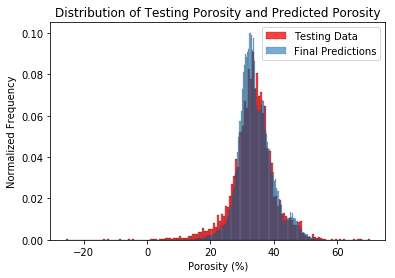

In [9]:
# Train the tuned random forest regressor on the entire dataset
# Again, these hyperparameters come from the optimzied model from the random search
rf_final = RandomForestRegressor(n_estimators=1600,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 max_features='auto',
                                 max_depth=100,
                                 bootstrap=True)

rf_final.fit(x_data, y_data)

# Create X values for prediction. We are only using the features retained from the recursive feature elimination
x_predict_data = data_need_predict.filter(['Depth', 'SP_NRM', 'Amp'])
final_predictions = rf_final.predict(x_predict_data)

# Convert predictions to percentage
final_predictions_p = final_predictions * 100

# Plot a histogram of the testing data and the final predictions to compare
original_data = data['PHIS_SS'].values*100
plt.figure()
sns.histplot(original_data, stat='density', label='Testing Data', color='red')
sns.histplot(final_predictions_p, stat='density', label='Final Predictions', alpha=.6)
plt.title('Distribution of Testing Porosity and Predicted Porosity')
plt.xlabel('Porosity (%)')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.show()

The histograms above show the distribution of porosity from the orginal data (measured from the well) and the predicted porosity. The real porosity shows a higher frequency of lower porosity data. Overall, the predicted porosity values seem reasonable and usable.

In [19]:
# Compare statistics of the testing data (old data) and predictions (new data)

# Stats for original data
o_mean = round(np.mean(original_data), 3)
o_sd = round(np.std(original_data), 3)
o_skew = round(stats.skew(original_data), 3)
o_kurt = round(stats.kurtosis(original_data), 3)

# Stats for new predicted data
n_mean = round(np.mean(final_predictions_p), 3)
n_sd = round(np.std(final_predictions_p), 3)
n_skew = round(stats.skew(final_predictions_p), 3)
n_kurt = round(stats.kurtosis(final_predictions_p), 3)

# Print stats
print('---------Random Forest Regressor Summary Statistics---------')
print('Testing data | Predicted data'.center(55))
print('-------------------------------------')
print('Mean: {} | {}'.format(str(o_mean).center(19), str(n_mean).center(15)))
print('Std. Deviation: {} | {}'.format(str(o_sd).center(9), str(n_sd).center(15)))
print('Skew: {} | {}'.format(str(o_skew).center(19), str(n_skew).center(15)))
print('Kurtosis: {} | {}'.format(str(o_kurt).center(15), str(n_kurt).center(15)))

---------Random Forest Regressor Summary Statistics---------
             Testing data | Predicted data             
-------------------------------------
Mean:        33.426       |      34.187    
Std. Deviation:   6.715   |      5.247     
Skew:        -0.437       |      0.433     
Kurtosis:      3.589      |      0.852     


The statistics above allow for a comparison between the testing data and the new, predicted porosity data. We expect the distribution of predicted porosity vlaues to be identical to the original dataset. This does assume that the wells that were used for training and testing were a true random sample of the larger well population of the area.

The difference of mean porosity values between the two datasets is less than 1% porosity units. The difference in standard deviaiton is just above 1% porosity units. The testing data shows a negative skew while the predicted data shows a positive skew. This is expected as earlier figures showed that the model overestimated porosity in lower porosity values. This means that the measured testing data had more data with lower porosity values. Finally we can look at kurtosis. The Scipy stats package measures kurtosis so that a value of 0 is a normal distribution. The predicted data is much closer to a normal distrubution than the testing data. The testing data includes a number of points that are more than 3 standard deviations aways from the mean, which increases the kurtosis value. 

The Random Forest regressor is an excellent model for predicting porosity from a combination of well and seismic data. The model shows a mean error of less than 1% in porosity and a standard deviation of less than 5%. This model is recommended for use on a field scale or larger. 

## Parting Comments

At the time of this project, I am a second year Masters student at the Univeristy of Texas at Austin focusing in geophysics. My research is a part of the Gulf Coast Carbon Commission at the Bureau of Economic Geology. I have been working towards creating a high resolution stratigraphic framework of intraslope growth-faulted subbasins for the purpose of Carbon Capture and Storage; advised by Dr. Tip Meckel. I enjoy merging classical geological thinking with computer science. I want to use every tool avaialable to further our understanding of the Earth and work towards greater goals.

I hope this was helpful,

*John Franey*

#### [email](mailto:johnfraney@utexas.edu) | [LinkedIn](https://www.linkedin.com/in/john-franey-455076192/)
___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
